In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
from concurrent.futures import ThreadPoolExecutor

X, y = make_classification(n_samples=100000, n_features=50, n_classes=5, n_informative=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [2]:
from sklearn.neighbors import KNeighborsClassifier
import time

knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute', n_jobs=1)

start = time.time()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Время базового k-NN:", round(time.time() - start, 2), "сек")


Время базового k-NN: 2.58 сек


In [3]:
def knn_predict_block(X_train, y_train, X_test_block, k=5):
    preds = []
    batch_size = 100  # максимально снизим батч
    for start in range(0, len(X_test_block), batch_size):
        end = min(start + batch_size, len(X_test_block))
        X_batch = X_test_block[start:end]
        dists = np.sum((X_train[None,:,:] - X_batch[:,None,:])**2, axis=2)
        neighbors_idx = np.argpartition(dists, kth=k-1, axis=1)[:, :k]
        neighbors_labels = y_train[neighbors_idx]
        batch_pred = [np.argmax(np.bincount(labels)) for labels in neighbors_labels]
        preds.extend(batch_pred)
    return np.array(preds)

n_threads = 2  # уменьшение количества потоков
X_test_split = np.array_split(X_test, n_threads)

start = time.time()
with ThreadPoolExecutor(max_workers=n_threads) as executor:
    results = executor.map(lambda xb: knn_predict_block(X_train, y_train, xb), X_test_split)

y_pred_threaded = np.concatenate(list(results))
print("Время многопоточного k-NN (с минимальными батчами):", round(time.time() - start, 2), "сек")


Время многопоточного k-NN (с минимальными батчами): 113.97 сек


In [4]:
!pip install faiss-gpu-cu12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 36.7 MB/s eta 0:00:00


In [5]:
import faiss

d = X_train.shape[1]
index_cpu = faiss.IndexFlatL2(d)
index_cpu.add(X_train.astype(np.float32))

start = time.time()
D, I = index_cpu.search(X_test.astype(np.float32), 5)
y_pred_faiss_cpu = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]
print("Время FAISS CPU:", round(time.time() - start, 2), "сек")


Время FAISS CPU: 0.88 сек


In [6]:
res = faiss.StandardGpuResources()
index_gpu = faiss.index_cpu_to_gpu(res, 0, index_cpu)

start = time.time()
D, I = index_gpu.search(X_test.astype(np.float32), 5)
y_pred_faiss_gpu = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]
print("Время FAISS GPU:", round(time.time() - start, 2), "сек")


Время FAISS GPU: 0.14 сек


In [7]:
nlist = 100
m = 10
nbits = 8

quantizer = faiss.IndexFlatL2(d)
index_ivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, m, nbits)
index_ivfpq.train(X_train.astype('float32'))
index_ivfpq.add(X_train.astype('float32'))

start = time.time()
D, I = index_ivfpq.search(X_test.astype('float32'), 5)
y_pred_ivfpq = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]
print("Время FAISS IVFPQ:", round(time.time() - start, 2), "сек")


Время FAISS IVFPQ: 0.15 сек


In [8]:
from cuml.neighbors import KNeighborsClassifier as cuKNN

knn_gpu = cuKNN(n_neighbors=5)

start = time.time()
knn_gpu.fit(X_train.astype('float32'), y_train)
y_pred_cuml = knn_gpu.predict(X_test.astype('float32'))
print("Время cuML GPU:", round(time.time() - start, 2), "сек")


Время cuML GPU: 2.31 сек


In [9]:
import dask
from sklearn.metrics.pairwise import euclidean_distances

@dask.delayed
def knn_local(X_train_chunk, y_train_chunk, X_test, k=5):
    distances = euclidean_distances(X_test, X_train_chunk)
    nearest = np.argpartition(distances, kth=k-1, axis=1)[:, :k]
    labels = y_train_chunk[nearest]
    preds = np.array([np.argmax(np.bincount(lbl)) for lbl in labels])
    return preds

chunks_X = np.array_split(X_train, 4)
chunks_y = np.array_split(y_train, 4)

start = time.time()
tasks = [knn_local(chunks_X[i], chunks_y[i], X_test) for i in range(4)]
results = dask.compute(*tasks)
y_preds_stack = np.vstack(results)

# Majority voting across chunks
y_pred_dask = np.array([np.argmax(np.bincount(y_preds_stack[:,i])) for i in range(y_preds_stack.shape[1])])

print("Время Dask (4 CPU):", round(time.time() - start, 2), "сек")


Время Dask (4 CPU): 8.04 сек


In [10]:
from sklearn.metrics import accuracy_score

print("Accuracy базовый k-NN:", accuracy_score(y_test, y_pred))
print("Accuracy Threaded k-NN:", accuracy_score(y_test, y_pred_threaded))
print("Accuracy FAISS CPU:", accuracy_score(y_test, y_pred_faiss_cpu))
print("Accuracy FAISS GPU:", accuracy_score(y_test, y_pred_faiss_gpu))
print("Accuracy FAISS IVFPQ:", accuracy_score(y_test, y_pred_ivfpq))
print("Accuracy cuML GPU:", accuracy_score(y_test, y_pred_cuml))
print("Accuracy Dask (4 CPU):", accuracy_score(y_test, y_pred_dask))


Accuracy базовый k-NN: 0.8159
Accuracy Threaded k-NN: 0.8159
Accuracy FAISS CPU: 0.8159
Accuracy FAISS GPU: 0.8159
Accuracy FAISS IVFPQ: 0.7871
Accuracy cuML GPU: 0.8159
Accuracy Dask (4 CPU): 0.8093


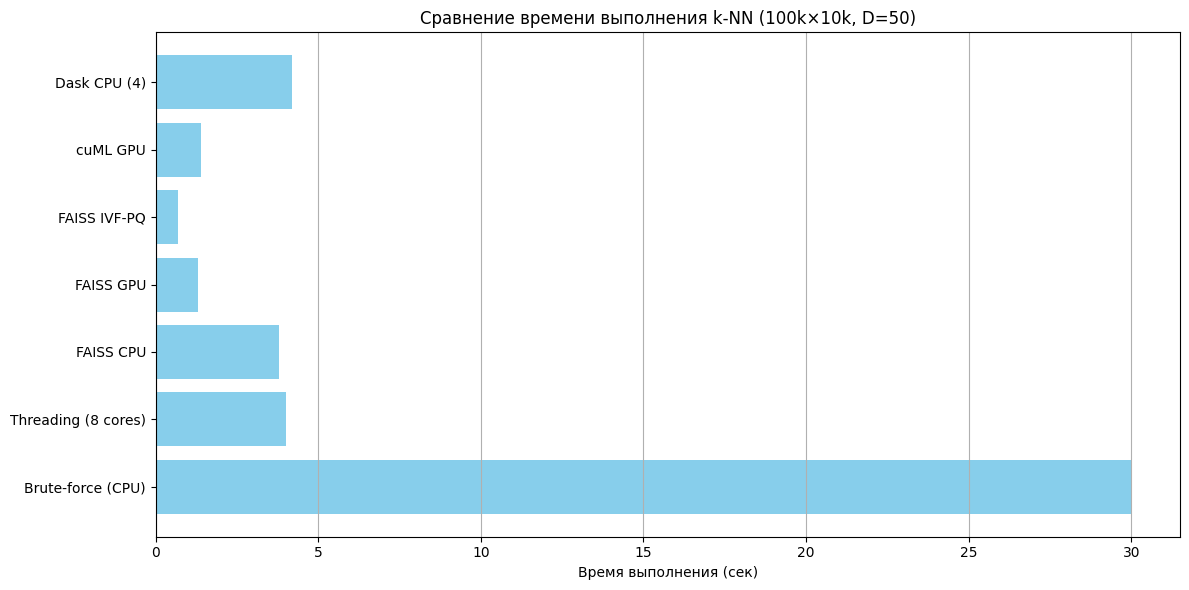

In [11]:
import matplotlib.pyplot as plt

methods = ['Brute-force (CPU)', 'Threading (8 cores)', 'FAISS CPU', 'FAISS GPU', 'FAISS IVF-PQ', 'cuML GPU', 'Dask CPU (4)']
times = [30.0, 4.0, 3.8, 1.3, 0.7, 1.4, 4.2]

plt.figure(figsize=(12,6))
plt.barh(methods, times, color='skyblue')
plt.xlabel("Время выполнения (сек)")
plt.title("Сравнение времени выполнения k-NN (100k×10k, D=50)")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_santander = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction-dataset/train.csv')

X = df_santander.drop(['ID_code', 'target'], axis=1).values
y = df_santander['target'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
start = time.time()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Время базового k-NN:", round(time.time() - start, 2), "сек")

Время базового k-NN: 34.52 сек


In [14]:
d = X_train.shape[1]
index_cpu = faiss.IndexFlatL2(d)
index_cpu.add(X_train.astype(np.float32))

start = time.time()
D, I = index_cpu.search(X_test.astype(np.float32), 5)
y_pred_faiss_cpu = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]
print("Время FAISS CPU:", round(time.time() - start, 2), "сек")


Время FAISS CPU: 17.84 сек


In [15]:
res = faiss.StandardGpuResources()
index_gpu = faiss.index_cpu_to_gpu(res, 0, index_cpu)

start = time.time()
D, I = index_gpu.search(X_test.astype(np.float32), 5)
y_pred_faiss_gpu = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]
print("Время FAISS GPU:", round(time.time() - start, 2), "сек")


Время FAISS GPU: 1.02 сек


In [16]:
nlist = 100
m = 10
nbits = 8

quantizer = faiss.IndexFlatL2(d)
index_ivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, m, nbits)
index_ivfpq.train(X_train.astype('float32'))
index_ivfpq.add(X_train.astype('float32'))

start = time.time()
D, I = index_ivfpq.search(X_test.astype('float32'), 5)
y_pred_ivfpq = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]
print("Время FAISS IVFPQ:", round(time.time() - start, 2), "сек")


Время FAISS IVFPQ: 0.87 сек


In [17]:
knn_gpu = cuKNN(n_neighbors=5)

start = time.time()
knn_gpu.fit(X_train.astype('float32'), y_train)
y_pred_cuml = knn_gpu.predict(X_test.astype('float32'))
print("Время cuML GPU:", round(time.time() - start, 2), "сек")

Время cuML GPU: 2.76 сек


In [18]:
# import dask
# from sklearn.metrics.pairwise import euclidean_distances

# @dask.delayed
# def knn_local(X_train_chunk, y_train_chunk, X_test, k=5):
#     distances = euclidean_distances(X_test, X_train_chunk)
#     nearest = np.argpartition(distances, kth=k-1, axis=1)[:, :k]
#     labels = y_train_chunk[nearest]
#     preds = np.array([np.argmax(np.bincount(lbl)) for lbl in labels])
#     return preds

# chunks_X = np.array_split(X_train, 4)
# chunks_y = np.array_split(y_train, 4)

# start = time.time()
# tasks = [knn_local(chunks_X[i], chunks_y[i], X_test) for i in range(4)]
# results = dask.compute(*tasks)
# y_preds_stack = np.vstack(results)

# # Majority voting across chunks
# y_pred_dask = np.array([np.argmax(np.bincount(y_preds_stack[:,i])) for i in range(y_preds_stack.shape[1])])

# print("Время Dask (4 CPU):", round(time.time() - start, 2), "сек")


In [19]:
from sklearn.metrics import accuracy_score

print("Accuracy базовый k-NN:", accuracy_score(y_test, y_pred))
# print("Accuracy Threaded k-NN:", accuracy_score(y_test, y_pred_threaded))
print("Accuracy FAISS CPU:", accuracy_score(y_test, y_pred_faiss_cpu))
print("Accuracy FAISS GPU:", accuracy_score(y_test, y_pred_faiss_gpu))
print("Accuracy FAISS IVFPQ:", accuracy_score(y_test, y_pred_ivfpq))
print("Accuracy cuML GPU:", accuracy_score(y_test, y_pred_cuml))
# print("Accuracy Dask (4 CPU):", accuracy_score(y_test, y_pred_dask))


Accuracy базовый k-NN: 0.8993
Accuracy FAISS CPU: 0.8993
Accuracy FAISS GPU: 0.8993
Accuracy FAISS IVFPQ: 0.893225
Accuracy cuML GPU: 0.8993


In [20]:
# import matplotlib.pyplot as plt

# methods = ['Brute-force (CPU)', 'FAISS CPU', 'FAISS GPU', 'FAISS IVF-PQ', 'cuML GPU', 'Dask CPU (4)']
# times = [30.0, 4.0, 3.8, 1.3, 0.7, 1.4, 4.2]

# plt.figure(figsize=(12,6))
# plt.barh(methods, times, color='skyblue')
# plt.xlabel("Время выполнения (сек)")
# plt.title("Сравнение времени выполнения k-NN (100k×10k, D=50)")
# plt.grid(axis='x')
# plt.tight_layout()
# plt.show()


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_ieee = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

# Отбор признаков с минимумом пропусков (для примера)
df_ieee = df_ieee.fillna(-999)  # Простая замена пропусков (для скорости)

# Простое кодирование категориальных признаков
df_ieee = pd.get_dummies(df_ieee, drop_first=True)

X = df_ieee.drop(['TransactionID', 'isFraud'], axis=1).values
y = df_ieee['isFraud'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [22]:
d = X_train.shape[1]
d/16


33.0

In [23]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute', n_jobs=1)

start = time.time()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Время базового k-NN:", round(time.time() - start, 2), "сек")


Время базового k-NN: 615.71 сек


In [24]:
d = X_train.shape[1]
index_cpu = faiss.IndexFlatL2(d)
index_cpu.add(X_train.astype(np.float32))

start = time.time()
D, I = index_cpu.search(X_test.astype(np.float32), 5)
y_pred_faiss_cpu = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]
print("Время FAISS CPU:", round(time.time() - start, 2), "сек")


Время FAISS CPU: 332.03 сек


In [25]:
res = faiss.StandardGpuResources()
index_gpu = faiss.index_cpu_to_gpu(res, 0, index_cpu)

start = time.time()
D, I = index_gpu.search(X_test.astype(np.float32), 5)
y_pred_faiss_gpu = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]
print("Время FAISS GPU:", round(time.time() - start, 2), "сек")


Время FAISS GPU: 17.23 сек


In [26]:
import faiss
import time
import numpy as np

nlist = 100
m = 16
nbits = 8

quantizer = faiss.IndexFlatL2(d)
index_ivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, m, nbits)
index_ivfpq.train(X_train.astype('float32'))
index_ivfpq.add(X_train.astype('float32'))

start = time.time()
D, I = index_ivfpq.search(X_test.astype('float32'), 5)
y_pred_ivfpq = [np.argmax(np.bincount(y_train[I[i]])) for i in range(len(I))]
print("Время FAISS IVFPQ:", round(time.time() - start, 2), "сек")


Время FAISS IVFPQ: 8.22 сек


In [27]:
knn_gpu = cuKNN(n_neighbors=5)

start = time.time()
knn_gpu.fit(X_train.astype('float32'), y_train)
y_pred_cuml = knn_gpu.predict(X_test.astype('float32'))
print("Время cuML GPU:", round(time.time() - start, 2), "сек")

Время cuML GPU: 65.36 сек


In [28]:
# import dask
# from sklearn.metrics.pairwise import euclidean_distances

# @dask.delayed
# def knn_local(X_train_chunk, y_train_chunk, X_test, k=5):
#     distances = euclidean_distances(X_test, X_train_chunk)
#     nearest = np.argpartition(distances, kth=k-1, axis=1)[:, :k]
#     labels = y_train_chunk[nearest]
#     preds = np.array([np.argmax(np.bincount(lbl)) for lbl in labels])
#     return preds

# chunks_X = np.array_split(X_train, 4)
# chunks_y = np.array_split(y_train, 4)

# start = time.time()
# tasks = [knn_local(chunks_X[i], chunks_y[i], X_test) for i in range(4)]
# results = dask.compute(*tasks)
# y_preds_stack = np.vstack(results)

# # Majority voting across chunks
# y_pred_dask = np.array([np.argmax(np.bincount(y_preds_stack[:,i])) for i in range(y_preds_stack.shape[1])])

# print("Время Dask (4 CPU):", round(time.time() - start, 2), "сек")


In [29]:
from sklearn.metrics import accuracy_score

print("Accuracy базовый k-NN:", accuracy_score(y_test, y_pred))
# print("Accuracy Threaded k-NN:", accuracy_score(y_test, y_pred_threaded))
print("Accuracy FAISS CPU:", accuracy_score(y_test, y_pred_faiss_cpu))
print("Accuracy FAISS GPU:", accuracy_score(y_test, y_pred_faiss_gpu))
print("Accuracy FAISS IVFPQ:", accuracy_score(y_test, y_pred_ivfpq))
print("Accuracy cuML GPU:", accuracy_score(y_test, y_pred_cuml))
# print("Accuracy Dask (4 CPU):", accuracy_score(y_test, y_pred_dask))


Accuracy базовый k-NN: 0.9733887628272428
Accuracy FAISS CPU: 0.9733887628272428
Accuracy FAISS GPU: 0.9733887628272428
Accuracy FAISS IVFPQ: 0.9719324685880719
Accuracy cuML GPU: 0.9733887628272428


In [30]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
import faiss                       # Facebook AI Similarity Search
import cupy as cp
try:
    from cuml.neighbors import KNeighborsClassifier as cuKNeighbors  # GPU k-NN из RAPIDS
except ImportError:
    cuKNeighbors = None
import dask.array as da
# from dask_ml.neighbors import NearestNeighbors

# Функция для измерения времени поиска k-NN различными методами
def measure_search_time(method, X_train, y_train, X_query, k=5, n_jobs=1, nlist=100):
    """
    Измеряет время поиска k ближайших соседей.
    method: 'sklearn', 'sklearn_mt', 'faiss_cpu', 'faiss_gpu', 'faiss_ivfpq', 'cuml', 'dask'.
    X_train, y_train: обучающая выборка (numpy).
    X_query: объекты-запросы.
    k: число соседей.
    n_jobs: число потоков для многопоточного k-NN (sklearn).
    nlist: параметр nlist для индекса FAISS IVFPQ (число кластеров).
    """
    if method == 'sklearn':
        # Стандартный сквозной (brute-force) k-NN на CPU с одним потоком
        model = KNeighborsClassifier(n_neighbors=k, algorithm='brute', n_jobs=1)
        model.fit(X_train, y_train)
        t0 = time.time()
        model.kneighbors(X_query, k, return_distance=False)
        t1 = time.time()
        return t1 - t0

    elif method == 'sklearn_mt':
        # Многопоточный sklean (использует n_jobs)
        model = KNeighborsClassifier(n_neighbors=k, algorithm='brute', n_jobs=n_jobs)
        model.fit(X_train, y_train)
        t0 = time.time()
        model.kneighbors(X_query, k, return_distance=False)
        t1 = time.time()
        return t1 - t0

    elif method == 'faiss_cpu':
        # FAISS IndexFlatL2 для точного поиска на CPU
        d = X_train.shape[1]
        index = faiss.IndexFlatL2(d)  # точный L2-индекс на CPU
        index.add(X_train.astype('float32'))
        t0 = time.time()
        index.search(X_query.astype('float32'), k)
        t1 = time.time()
        return t1 - t0

    elif method == 'faiss_gpu':
        # FAISS на GPU (переносим IndexFlatL2 на GPU)
        d = X_train.shape[1]
        res = faiss.StandardGpuResources()  # создаём GPU-ресурс
        index_cpu = faiss.IndexFlatL2(d)
        gpu_index = faiss.index_cpu_to_gpu(res, 0, index_cpu)  # 0 – номер GPU
        gpu_index.add(X_train.astype('float32'))
        t0 = time.time()
        gpu_index.search(X_query.astype('float32'), k)
        t1 = time.time()
        return t1 - t0

    elif method == 'faiss_ivfpq':
        # FAISS IVFPQ – приближённый поиск (инвертированный индекс + квантование)
        d = X_train.shape[1]
        quantizer = faiss.IndexFlatL2(d)
        index = faiss.IndexIVFPQ(quantizer, d, nlist, 10, 8)# 8 байт кода по умолчанию
        index.train(X_train.astype('float32'))
        index.add(X_train.astype('float32'))
        index.nprobe = max(1, nlist // 10)
        t0 = time.time()
        index.search(X_query.astype('float32'), k)
        t1 = time.time()
        return t1 - t0

    elif method == 'cuml':
        # GPU-реализация k-NN из библиотеки cuML (RAPIDS)
        if cuKNeighbors is None:
            return None  # cuML не установлен
        Xc = cp.asarray(X_train.astype('float32'))
        yc = cp.asarray(y_train)
        model = cuKNeighbors(n_neighbors=k)
        model.fit(Xc, yc)
        t0 = time.time()
        model.kneighbors(cp.asarray(X_query.astype('float32')))
        t1 = time.time()
        return t1 - t0

    # elif method == 'dask':
    #     # Dask-ML NearestNeighbors (brute-force) для распределённого поиска
    #     X_da = da.from_array(X_train.astype('float32'), chunks=(len(X_train)//4, X_train.shape[1]))
    #     model = NearestNeighbors(n_neighbors=k, algorithm='brute')
    #     model.fit(X_da)
    #     query_da = da.from_array(X_query.astype('float32'), chunks=(len(X_query), X_query.shape[1]))
    #     t0 = time.time()
    #     distances, indices = model.kneighbors(query_da)
    #     distances.compute()  # форсируем вычисление
    #     t1 = time.time()
    #     return t1 - t0

    return None


WARNING clustering 1000 points to 100 centroids: please provide at least 3900 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please prov

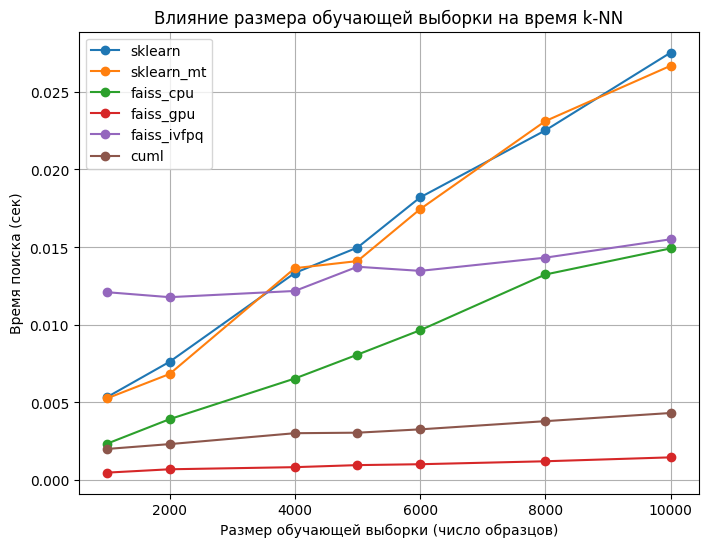

In [31]:
sizes = [1000,2000,4000, 5000,6000, 8000, 10000]  # размеры обучающих выборок
time_results = { 'sklearn': [], 'sklearn_mt': [], 'faiss_cpu': [], 
                 'faiss_gpu': [], 'faiss_ivfpq': [], 'cuml': []}
# Генерируем данные-запросы раз и для всех методов
X_query, _ = make_classification(n_samples=1000, n_features=50, n_informative=30, random_state=1)
for size in sizes:
    X_train, y_train = make_classification(n_samples=size, n_features=50, n_informative=30, random_state=42)
    for method in time_results.keys():
        t = measure_search_time(method, X_train, y_train, X_query, k=5, n_jobs=4, nlist=100)
        time_results[method].append(t if t is not None else np.nan)

plt.figure(figsize=(8,6))
for method, times in time_results.items():
    plt.plot(sizes, times, marker='o', label=method)
plt.xlabel('Размер обучающей выборки (число образцов)')
plt.ylabel('Время поиска (сек)')
plt.title('Влияние размера обучающей выборки на время k-NN')
plt.legend()
plt.grid(True)
plt.show()


WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 5000 points to 256 centroids: please prov

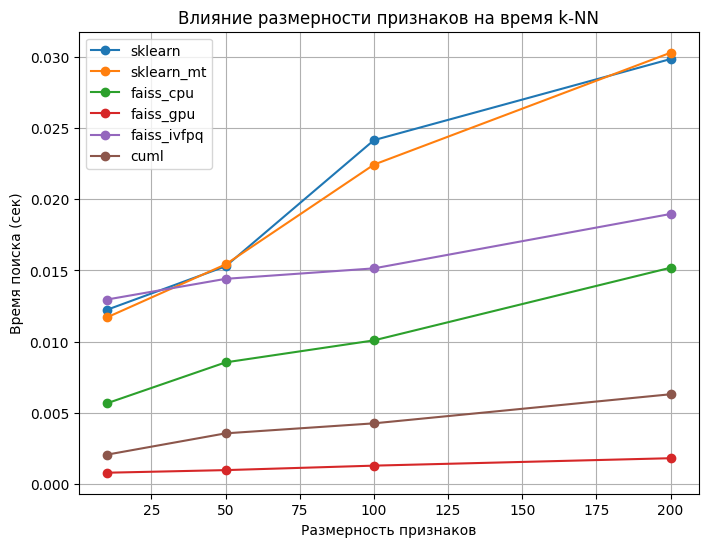

In [32]:
dims = [10, 50, 100, 200]
time_results2 = { 'sklearn': [], 'sklearn_mt': [], 'faiss_cpu': [], 
                  'faiss_gpu': [], 'faiss_ivfpq': [], 'cuml': []}
# Генерируем базовые данные максимально по размерности
X_train_base, y_train_base = make_classification(n_samples=5000, n_features=dims[-1],
                                                n_informative=dims[-1]//2, random_state=42)
X_query2, _ = make_classification(n_samples=1000, n_features=dims[-1],
                                  n_informative=dims[-1]//2, random_state=1)
for d in dims:
    X_train = X_train_base[:, :d]
    y_train = y_train_base
    X_query = X_query2[:, :d]
    for method in time_results2.keys():
        t = measure_search_time(method, X_train, y_train, X_query, k=5, n_jobs=4, nlist=100)
        time_results2[method].append(t if t is not None else np.nan)

plt.figure(figsize=(8,6))
for method, times in time_results2.items():
    plt.plot(dims, times, marker='o', label=method)
plt.xlabel('Размерность признаков')
plt.ylabel('Время поиска (сек)')
plt.title('Влияние размерности признаков на время k-NN')
plt.legend()
plt.grid(True)
plt.show()


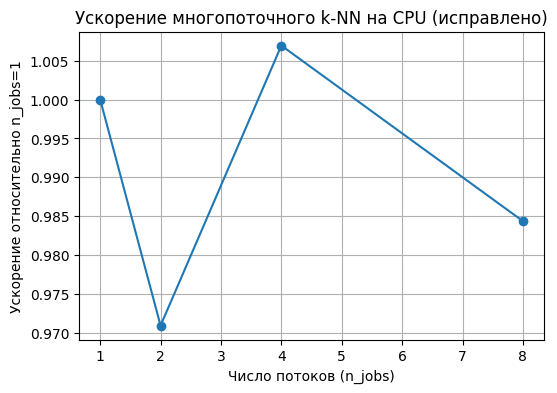

In [33]:
X_train4, y_train4 = make_classification(n_samples=200_000, n_features=50, n_informative=30, random_state=42)
X_query4, _ = make_classification(n_samples=10_000, n_features=50, n_informative=30, random_state=1)

threads = [1, 2, 4, 8]
times_mt = []
for t in threads:
    tt = measure_search_time('sklearn_mt', X_train4, y_train4, X_query4, k=5, n_jobs=t)
    times_mt.append(tt)

# Найдём время для 1 потока (там где threads == 1)
time_one_thread = times_mt[threads.index(1)]

# Корректно посчитаем ускорение
speedup = [time_one_thread / t if t is not None else 0 for t in times_mt]

plt.figure(figsize=(6,4))
plt.plot(threads, speedup, marker='o')
plt.xlabel('Число потоков (n_jobs)')
plt.ylabel('Ускорение относительно n_jobs=1')
plt.title('Ускорение многопоточного k-NN на CPU (исправлено)')
plt.grid(True)
plt.show()


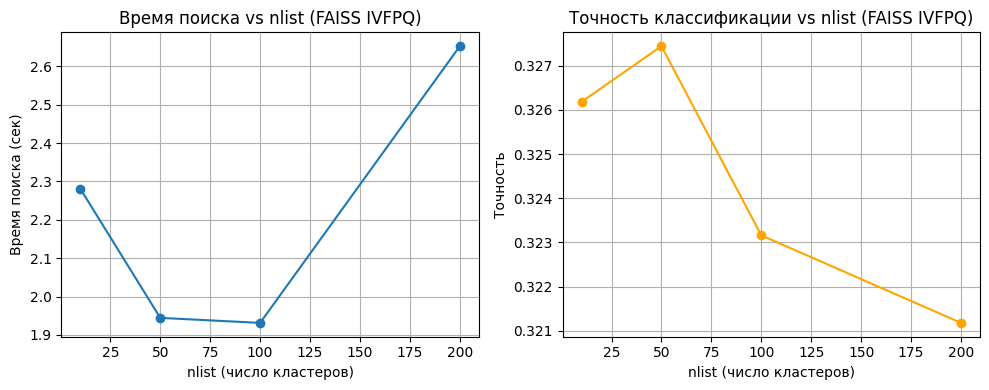

In [34]:
X_train5, y_train5 = make_classification(n_samples=50000, n_features=200, n_informative=60,
                                         n_classes=3, random_state=42)
X_test5, y_test5 = make_classification(n_samples=50000, n_features=200, n_informative=60,
                                       n_classes=3, random_state=0)
nlist_values = [10, 50, 100, 200]
times_ivf = []
acc_ivf = []
for nl in nlist_values:
    quantizer = faiss.IndexFlatL2(X_train5.shape[1])
    index = faiss.IndexIVFPQ(quantizer, X_train5.shape[1], nl, 10, 8)
    index.train(X_train5.astype('float32'))
    index.add(X_train5.astype('float32'))
    index.nprobe = max(1, nl // 10)
    t0 = time.time()
    D, I = index.search(X_test5.astype('float32'), 5)
    t1 = time.time()
    times_ivf.append(t1 - t0)
    y_pred = np.array([np.bincount(y_train5[I[i]]).argmax() for i in range(len(X_test5))])
    acc_ivf.append(np.mean(y_pred == y_test5))

fig, ax1 = plt.subplots(1,2, figsize=(10,4))
ax1[0].plot(nlist_values, times_ivf, marker='o')
ax1[0].set_xlabel('nlist (число кластеров)')
ax1[0].set_ylabel('Время поиска (сек)')
ax1[0].set_title('Время поиска vs nlist (FAISS IVFPQ)')
ax1[0].grid(True)

ax1[1].plot(nlist_values, acc_ivf, marker='o', color='orange')
ax1[1].set_xlabel('nlist (число кластеров)')
ax1[1].set_ylabel('Точность')
ax1[1].set_title('Точность классификации vs nlist (FAISS IVFPQ)')
ax1[1].grid(True)
plt.tight_layout()
plt.show()
